## Supervised contrastive loss functions

In [71]:
!pip install tensorflow-addons==0.8.3
!pip install tensorflow==2.2.0-rc3

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0-rc3 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2)
ERROR: No matching distribution found for tensorflow==2.2.0-rc3


In [72]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import tensorflow as tf


class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''

    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])


class DenseLeakyReluLayer(tf.keras.layers.Layer):
    '''A dense layer followed by a LeakyRelu layer
    '''

    def __init__(self, n, alpha=0.3):
        super(DenseLeakyReluLayer, self).__init__()
        self.dense = tf.keras.layers.Dense(n, activation=None)
        self.lrelu = tf.keras.layers.LeakyReLU(alpha=alpha)

    def call(self, input_tensor):
        x = self.dense(input_tensor)
        return self.lrelu(x)


class Encoder(tf.keras.Model):
    '''An encoder network, E(·), which maps an augmented image x to a representation vector, r = E(x) ∈ R^{DE}
    '''

    def __init__(self, normalize=True, activation='relu'):
        super(Encoder, self).__init__(name='')
        if activation == 'leaky_relu':
            self.hidden1 = DenseLeakyReluLayer(256)
            self.hidden2 = DenseLeakyReluLayer(256)
        else:
            self.hidden1 = tf.keras.layers.Dense(256, activation=activation)
            self.hidden2 = tf.keras.layers.Dense(256, activation=activation)

        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()

    def call(self, input_tensor, training=False):
        x = self.hidden1(input_tensor, training=training)
        x = self.hidden2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        return x


class Projector(tf.keras.Model):
    '''
    A projection network, P(·), which maps the normalized representation vector r into a vector z = P(r) ∈ R^{DP} 
    suitable for computation of the contrastive loss.
    '''

    def __init__(self, n, normalize=True, activation='relu'):
        super(Projector, self).__init__(name='')
        if activation == 'leaky_relu':
            self.dense = DenseLeakyReluLayer(256)
            self.dense2 = DenseLeakyReluLayer(256)
        else:
            self.dense = tf.keras.layers.Dense(256, activation=activation)
            self.dense2 = tf.keras.layers.Dense(256, activation=activation)

        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()

    def call(self, input_tensor, training=False):
        x = self.dense(input_tensor, training=training)
        x = self.dense2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        return x


class SoftmaxPred(tf.keras.Model):
    '''For stage 2, simply a softmax on top of the Encoder.
    '''

    def __init__(self, num_classes=10):
        super(SoftmaxPred, self).__init__(name='')
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, input_tensor, training=False):
        return self.dense(input_tensor, training=training)


class MLP(tf.keras.Model):
    '''A simple baseline MLP with the same architecture to Encoder + Softmax/Regression output.
    '''

    def __init__(self, num_classes=10, normalize=True, regress=False, activation='relu'):
        super(MLP, self).__init__(name='')
        if activation == 'leaky_relu':
            self.hidden1 = DenseLeakyReluLayer(256)
            self.hidden2 = DenseLeakyReluLayer(256)
        else:
            self.hidden1 = tf.keras.layers.Dense(256, activation=activation)
            self.hidden2 = tf.keras.layers.Dense(256, activation=activation)
        self.normalize = normalize
        if self.normalize:
            self.norm = UnitNormLayer()
        if not regress:
            self.output_layer = tf.keras.layers.Dense(
                num_classes, activation='softmax')
        else:
            self.output_layer = tf.keras.layers.Dense(1)

    def call(self, input_tensor, training=False):
        x = self.hidden1(input_tensor, training=training)
        x = self.hidden2(x, training=training)
        if self.normalize:
            x = self.norm(x)
        preds = self.output_layer(x, training=training)
        return preds

    def get_last_hidden(self, input_tensor):
        '''Get the last hidden layer before prediction.
        '''
        x = self.hidden1(input_tensor, training=False)
        x = self.hidden2(x, training=False)
        if self.normalize:
            x = self.norm(x)
        return x

In [74]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa


def pdist_euclidean(A):
    # Euclidean pdist
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


def square_to_vec(D):
    '''Convert a squared form pdist matrix to vector form.
    '''
    n = D.shape[0]
    triu_idx = np.triu_indices(n, k=1)
    d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:   
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss


def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses 
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].    
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss. 
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from: 
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss

In [75]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [76]:
# global configs
EPOCHS = 20
# DATA = 'mnist'
DATA = 'fashion_mnist'
NORMALIZE_EMBEDDING = True
# NORMALIZE_EMBEDDING = False
N_DATA_TRAIN = 60000
# BATCH_SIZE = 32
BATCH_SIZE = 1024 # batch_size for pre-training
PROJECTION_DIM = 128
# WRITE_SUMMARY = True
WRITE_SUMMARY = False

ACTIVATION = 'leaky_relu'
LR = 0.5 # learning rate for pre-training

In [77]:
!mkdir -p logs/

In [78]:
optimizer = tf.keras.optimizers.Adam(lr=LR)
optimizer2 = tf.keras.optimizers.Adam() # with default lr

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [79]:
if DATA == 'mnist':
    mnist = tf.keras.datasets.mnist
elif DATA == 'fashion_mnist':
    mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28).astype(np.float32)
x_test = x_test.reshape(-1, 28*28).astype(np.float32)
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [80]:
# simulate low data regime for training
n_train = x_train.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [81]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)

train_ds2 = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [82]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [83]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [84]:
@tf.function
# train step for the multiclass N-pair loss
def train_step_npair(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = multiclass_npairs_loss(z, y)

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

In [85]:
@tf.function
def test_step_npair(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = multiclass_npairs_loss(z, y)
    test_loss(t_loss)

In [86]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        train_step_npair(x, y)

    for x_te, y_te in test_ds:
        test_step_npair(x_te, y_te)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        test_loss.result()))

Epoch 1, Loss: 6.416479110717773, Test Loss: 6.33054256439209
Epoch 2, Loss: 6.317345142364502, Test Loss: 6.2824602127075195
Epoch 3, Loss: 6.2835822105407715, Test Loss: 6.265728950500488
Epoch 4, Loss: 6.261234760284424, Test Loss: 6.246376037597656
Epoch 5, Loss: 6.251151084899902, Test Loss: 6.236468315124512
Epoch 6, Loss: 6.243375301361084, Test Loss: 6.227169513702393
Epoch 7, Loss: 6.232974529266357, Test Loss: 6.218189716339111
Epoch 8, Loss: 6.2234416007995605, Test Loss: 6.208786964416504
Epoch 9, Loss: 6.212925910949707, Test Loss: 6.2051496505737305
Epoch 10, Loss: 6.207983493804932, Test Loss: 6.19705057144165
Epoch 11, Loss: 6.199690341949463, Test Loss: 6.1935577392578125
Epoch 12, Loss: 6.1991167068481445, Test Loss: 6.187407493591309
Epoch 13, Loss: 6.19368314743042, Test Loss: 6.187204837799072
Epoch 14, Loss: 6.19149112701416, Test Loss: 6.190700531005859
Epoch 15, Loss: 6.188543319702148, Test Loss: 6.185290336608887
Epoch 16, Loss: 6.185776710510254, Test Loss: 6

In [87]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [88]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [89]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


In [90]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [91]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [92]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test
# x_te_proj_df.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


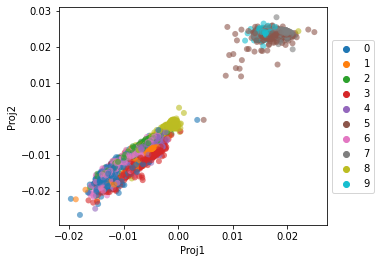

In [93]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


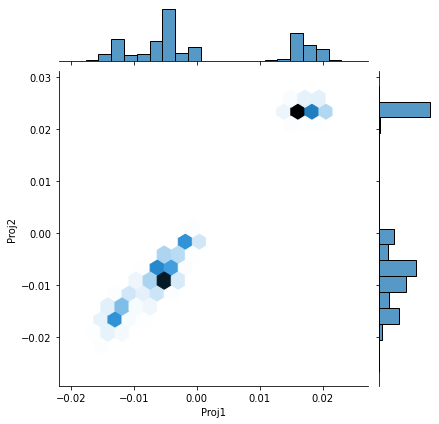

In [94]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );

In [95]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


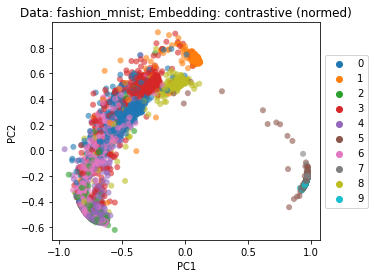

In [96]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_contrastive_embed.png' % DATA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


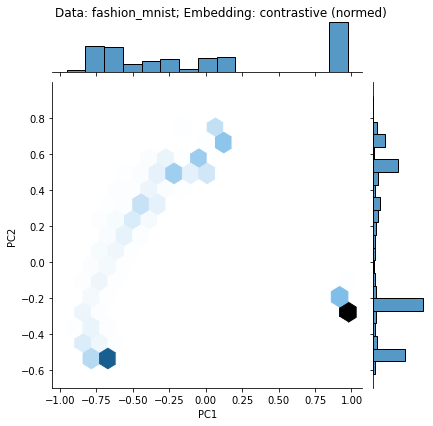

In [97]:
g = sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_contrastive_embed.png' % DATA)

In [98]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


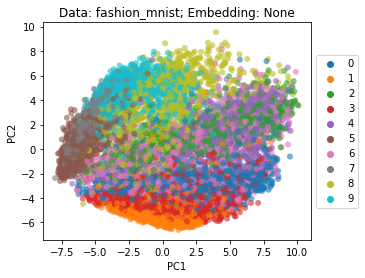

In [99]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_no_embed.png' % DATA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


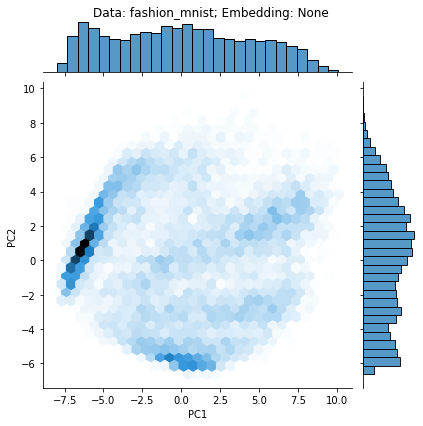

In [100]:
g = sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_no_embed.png' % DATA)

## Linear layer using a softmax loss

In [101]:
softmax = SoftmaxPred()

In [102]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [103]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [104]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer2.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [105]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [106]:
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [107]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds2:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.9253937005996704, Acc: 72.64166259765625, Test Loss: 0.6680856943130493, Test Acc: 76.29000091552734
Epoch 2, Loss: 0.5869759321212769, Acc: 79.44833374023438, Test Loss: 0.5993422269821167, Test Acc: 78.30999755859375
Epoch 3, Loss: 0.5420724749565125, Acc: 80.82666015625, Test Loss: 0.5743396282196045, Test Acc: 79.37999725341797
Epoch 4, Loss: 0.5223190188407898, Acc: 81.3933334350586, Test Loss: 0.5616853833198547, Test Acc: 79.97999572753906
Epoch 5, Loss: 0.5106798410415649, Acc: 81.75167083740234, Test Loss: 0.5537038445472717, Test Acc: 80.0199966430664
Epoch 6, Loss: 0.5026856660842896, Acc: 81.9433364868164, Test Loss: 0.5466107130050659, Test Acc: 80.40999603271484
Epoch 7, Loss: 0.49652519822120667, Acc: 82.0616683959961, Test Loss: 0.5412678122520447, Test Acc: 80.45999908447266
Epoch 8, Loss: 0.49153679609298706, Acc: 82.21666717529297, Test Loss: 0.5370091199874878, Test Acc: 80.75
Epoch 9, Loss: 0.48709121346473694, Acc: 82.39666748046875, Test Loss: 0.

In [108]:
test_acc.result().numpy()

0.8163

## Supervised NT-Xent

In [109]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [110]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [111]:
@tf.function
# train step for the multiclass N-pair loss
def train_step_sup_nt_xent(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = supervised_nt_xent_loss(z, y, temperature=0.1)

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

In [112]:
@tf.function
def test_step_sup_nt_xent(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = supervised_nt_xent_loss(z, y, temperature=0.1)
    test_loss(t_loss)

In [113]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        train_step_sup_nt_xent(x, y)

    for x_te, y_te in test_ds:
        test_step_sup_nt_xent(x_te, y_te)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        test_loss.result()))

Epoch 1, Loss: 8.721634864807129, Test Loss: 8.548921585083008
Epoch 2, Loss: 8.494729995727539, Test Loss: 8.43835163116455
Epoch 3, Loss: 8.404962539672852, Test Loss: 8.358758926391602
Epoch 4, Loss: 8.31875991821289, Test Loss: 8.289648056030273
Epoch 5, Loss: 8.260101318359375, Test Loss: 8.245220184326172
Epoch 6, Loss: 8.213944435119629, Test Loss: 8.204469680786133
Epoch 7, Loss: 8.170351028442383, Test Loss: 8.167376518249512
Epoch 8, Loss: 8.12153434753418, Test Loss: 8.109542846679688
Epoch 9, Loss: 8.05423641204834, Test Loss: 8.055569648742676
Epoch 10, Loss: 7.984165191650391, Test Loss: 7.974059104919434
Epoch 11, Loss: 7.91441011428833, Test Loss: 7.886310577392578
Epoch 12, Loss: 7.812982559204102, Test Loss: 7.832029819488525
Epoch 13, Loss: 7.747930526733398, Test Loss: 7.762152194976807
Epoch 14, Loss: 7.704179286956787, Test Loss: 7.736922264099121
Epoch 15, Loss: 7.668952465057373, Test Loss: 7.729203224182129
Epoch 16, Loss: 7.64360237121582, Test Loss: 7.6976027

In [114]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [115]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [116]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


In [117]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [118]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [119]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test
# x_te_proj_df.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


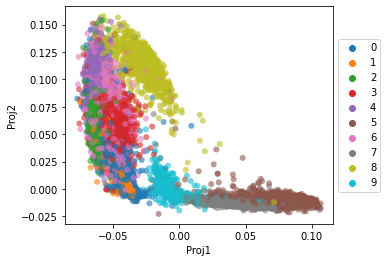

In [120]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


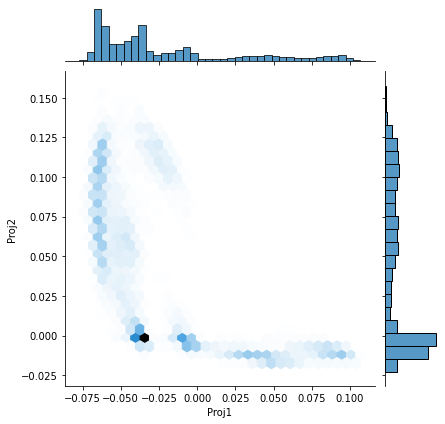

In [121]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );

In [122]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


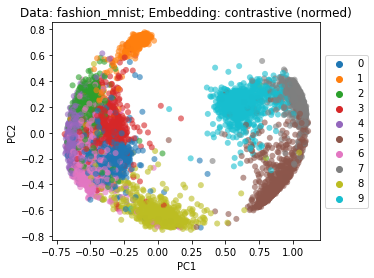

In [123]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_contrastive_embed.png' % DATA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


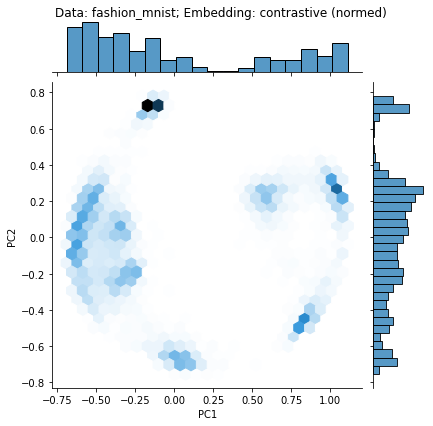

In [124]:
g = sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_contrastive_embed.png' % DATA)

In [125]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


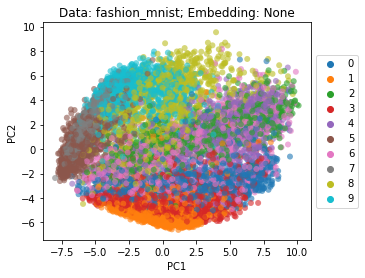

In [126]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_no_embed.png' % DATA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


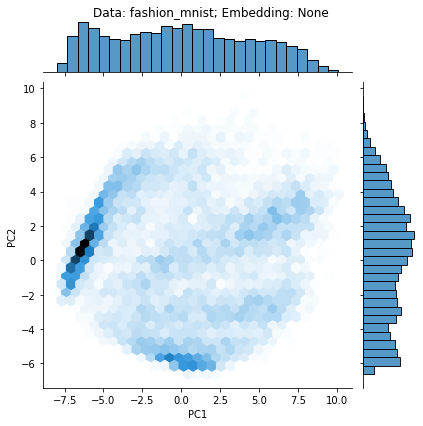

In [127]:
g = sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_no_embed.png' % DATA)

## Linear layer using a softmax loss

In [128]:
softmax = SoftmaxPred()

In [129]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [130]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [131]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer2.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [132]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)

    t_loss = cce_loss_obj(y, y_preds)

    test_loss(t_loss)
    test_acc(y, y_preds)

In [133]:
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [134]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds2:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.8379709720611572, Acc: 77.6816635131836, Test Loss: 0.6665043830871582, Test Acc: 80.37999725341797
Epoch 2, Loss: 0.5831225514411926, Acc: 82.61000061035156, Test Loss: 0.5766881108283997, Test Acc: 81.7300033569336
Epoch 3, Loss: 0.5180712938308716, Acc: 83.80000305175781, Test Loss: 0.5336226224899292, Test Acc: 82.55000305175781
Epoch 4, Loss: 0.4838063418865204, Acc: 84.40333557128906, Test Loss: 0.510316014289856, Test Acc: 83.17000579833984
Epoch 5, Loss: 0.46294695138931274, Acc: 84.77333068847656, Test Loss: 0.49396950006484985, Test Acc: 83.52000427246094
Epoch 6, Loss: 0.44898319244384766, Acc: 85.06500244140625, Test Loss: 0.48393288254737854, Test Acc: 83.63999938964844
Epoch 7, Loss: 0.4389427602291107, Acc: 85.25, Test Loss: 0.47597113251686096, Test Acc: 83.59000396728516
Epoch 8, Loss: 0.4314029812812805, Acc: 85.40833282470703, Test Loss: 0.47024935483932495, Test Acc: 83.72000122070312
Epoch 9, Loss: 0.4255247712135315, Acc: 85.54499816894531, Test L